In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
labeled = pd.read_csv('../company_with_score.csv',index_col=0)
test_index = pd.read_csv('../Data/test_index.csv',index_col=0)
master = pd.read_csv('../master_data.csv',index_col=0)
master = master[master['CompanyId'] != -999999]
# drop three columns (all 0)
master.drop(columns=['USAGE_APP10_SYSCOUNT','USAGE_FEAT10_SYSCOUNT','ProductFamily_B_count','ProductFamily_D_Provider3_count'],inplace=True)
master.reset_index(drop=True,inplace=True)
labeled.reset_index(drop=True,inplace=True)
master['YearMonth'] = master['YearMonth'].astype('str')
master['recent'] = max(master['YearMonth'])

In [3]:
master['YearMonth'] = pd.to_datetime(master['YearMonth'],format='%Y%m')
master['recent'] = pd.to_datetime(master['recent'],format='%Y%m')
master['exponential'] = ((master['YearMonth'] - master['recent'])//np.timedelta64(1, 'M'))
labeled.rename(columns={'CompanyID':'CompanyId'},inplace=True)
master

,CompanyId,YearMonth,USAGE_APP1_SYSCOUNT,USAGE_APP2_SYSCOUNT,USAGE_APP3_SYSCOUNT,USAGE_APP4_SYSCOUNT,USAGE_APP5_SYSCOUNT,USAGE_APP6_SYSCOUNT,USAGE_APP7_SYSCOUNT,USAGE_APP8_SYSCOUNT,...,ProductFamily_A_High_count,ProductFamily_C_Entry_count,ProductFamily_C_Mid_count,ProductFamily_C_High_count,ProductFamily_D_Category1_count,ProductFamily_D_Category2_count,ProductFamily_D_Provider1_count,ProductFamily_D_Provider2_count,recent,exponential
0,11626019,2018-05-01,0,0,2,0,0,0,0,0,...,4,2,2,0,0,0,0,0,2021-12-01,-44
1,11955219,2018-05-01,1,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,2021-12-01,-44
2,11560557,2018-05-01,2,2,0,0,2,18,0,0,...,4,0,10,6,0,0,0,0,2021-12-01,-44
3,12717505,2018-05-01,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,0,2021-12-01,-44
4,11622667,2018-05-01,0,0,2,0,0,0,0,0,...,0,5,2,0,0,0,0,0,2021-12-01,-44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267024,11559053,2021-12-01,3,8,13,0,5,136,0,0,...,0,98,34,0,0,0,0,0,2021-12-01,0
267025,11768662,2021-12-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021-12-01,0
267026,11670070,2021-12-01,19,16,20,1,0,0,0,0,...,16,14,11,0,0,0,0,0,2021-12-01,0
267027,11730030,2021-12-01,5,1,0,0,0,0,0,0,...,0,6,6,0,0,0,0,0,2021-12-01,0


In [4]:
trans_binary_columns = ['USAGE_APP1_SYSCOUNT', 
                        'USAGE_APP2_SYSCOUNT',
                        'USAGE_APP3_SYSCOUNT', 
                        'USAGE_APP4_SYSCOUNT', 
                        'USAGE_APP5_SYSCOUNT',
                        'USAGE_APP6_SYSCOUNT', 
                        'USAGE_APP7_SYSCOUNT',
                        'USAGE_APP8_SYSCOUNT',
                        'USAGE_APP9_SYSCOUNT', 
                        'USAGE_APP11_SYSCOUNT',
                        'USAGE_FEAT2_SYSCOUNT',
                        'USAGE_FEAT6_SYSCOUNT',
                        'USAGE_FEAT7_SYSCOUNT',
                        'USAGE_FEAT8_SYSCOUNT',
                        'USAGE_FEAT9_SYSCOUNT',
                        'USAGE_FEAT13_SYSCOUNT',
                        'USAGE_PROTOCOL4_SYSCOUNT',
                        'USAGE_PROTOCOL5_SYSCOUNT',
                        'USAGE_VIRT1_SYSCOUNT',
                        'USAGE_VIRT2_SYSCOUNT',
                        'ProductFamily_D_count',
                        'ProductFamily_E_count',
                        'ProductFamily_A_Mid_count',
                        'ProductFamily_A_High_count',
                        'ProductFamily_C_High_count',
                        'ProductFamily_D_Category1_count',
                        'ProductFamily_D_Category2_count',
                        'ProductFamily_D_Provider1_count',
                        'ProductFamily_D_Provider2_count']

In [5]:
binary = master[['CompanyId']+trans_binary_columns].groupby(['CompanyId']).max()
binary = binary > 0

In [6]:
for i in master.columns[2:-2]:
    if i not in trans_binary_columns:
        master[i] = np.log(master[i]+1)

In [7]:
alpha = 1.1
denominator = 0
for i in range(-44,1):
    denominator += alpha**i

In [8]:
def decaying(alpha, company_id, df):
    row = [company_id]
    df_comp = df[df['CompanyId']==company_id]
    for col in df.columns[2:-2]:
        if col in trans_binary_columns:
            row.append(binary.loc[company_id,col])
        else:
            fin_val = 0
            for val, power in zip(df_comp[col].values, df_comp['exponential'].values):
                fin_val += val*(alpha**power)
            row.append(fin_val/denominator)
    return row

100%|██████████████████████████████████████| 7345/7345 [00:24<00:00, 298.35it/s]


<AxesSubplot:>

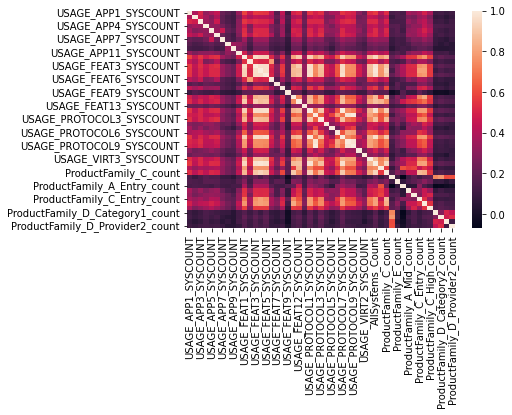

In [9]:
weighted_master = pd.DataFrame(columns=master.columns)
weighted_master.drop(columns=['YearMonth','recent', 'exponential'], inplace=True)
company_ids = master['CompanyId'].value_counts().index
for company_id in tqdm(company_ids):
    weighted_master.loc[len(weighted_master.index)] = decaying(alpha, company_id, master)
weighted_master['CompanyId'] = weighted_master['CompanyId'].astype('int64')
sns.heatmap(weighted_master[weighted_master.columns[1:]].corr())

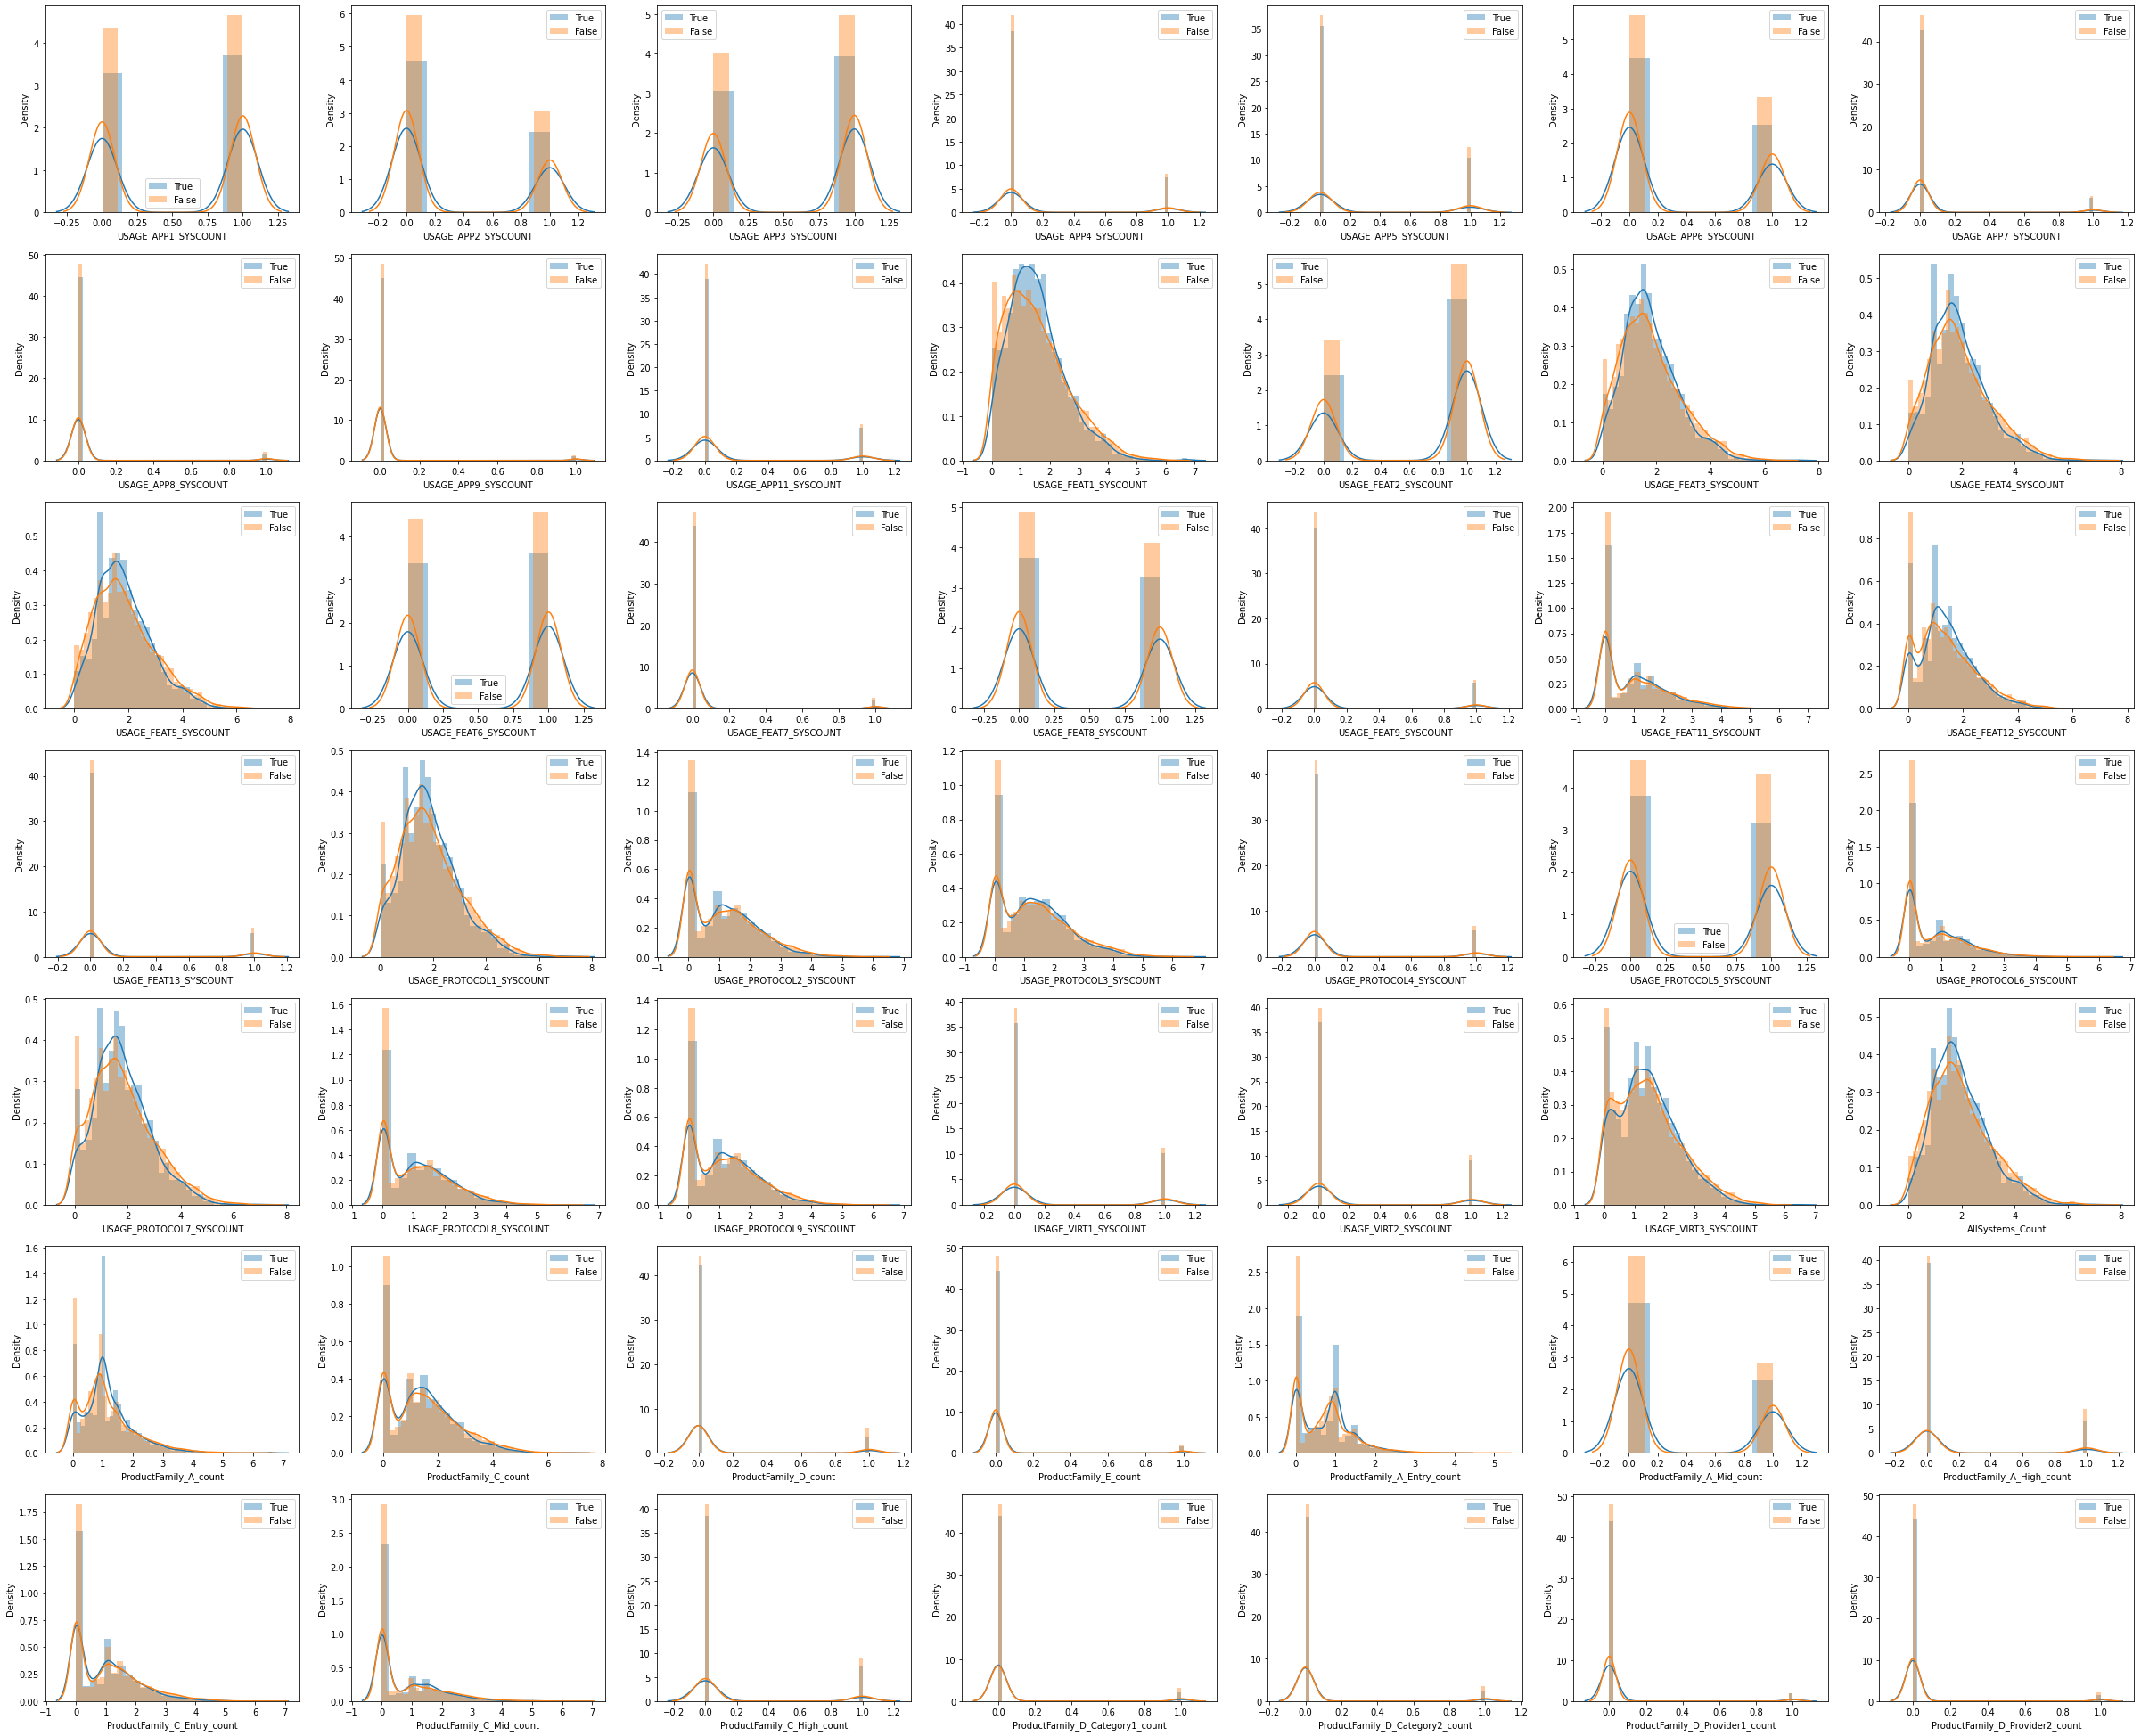

In [10]:
weighted_master=weighted_master.merge(labeled,on='CompanyId')
f, axs = plt.subplots(7,7,figsize=(42, 35))
for idx, col in enumerate(weighted_master.columns[1:-2]):
    sns.distplot(weighted_master[weighted_master['early_adopter'] == True][col], label='True', ax=axs[idx//7][idx%7])
    sns.distplot(weighted_master[weighted_master['early_adopter'] == False][col], label='False', ax=axs[idx//7][idx%7])
    axs[idx//7][idx%7].legend()

In [11]:
weighted_master['test'] = test_index['test']
def rf(data):
    train = data[data['test']==0]
    test = data[data['test']==1]
    Xtrain = train.loc[:,train.columns[1:-3]]
    ytrain = train['early_adopter']
    Xtest = test.loc[:,test.columns[1:-3]]
    ytest = test['early_adopter']
    lr = RandomForestClassifier(n_estimators=1000).fit(Xtrain, ytrain)
    return lr.score(Xtest,ytest), 1 - ytest.mean()

In [12]:
rf(weighted_master)

(0.721546170365068, 0.690050107372942)

In [13]:
X = weighted_master.loc[:,weighted_master.columns[1:-3]]
y = weighted_master['early_adopter']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
rf1 = RandomForestClassifier(n_estimators=1000).fit(Xtrain, ytrain)
rf1.score(Xtest,ytest)

0.7263444520081688

In [14]:
1-ytest.mean()

0.7066031313818925

In [15]:
feature_imp = pd.Series(rf1.feature_importances_,
       index=Xtrain.columns).sort_values(ascending=True)
feature_imp

ProductFamily_E_count              0.001545
USAGE_APP8_SYSCOUNT                0.001732
USAGE_APP9_SYSCOUNT                0.001773
ProductFamily_D_Category1_count    0.002050
ProductFamily_D_Provider2_count    0.002102
USAGE_FEAT7_SYSCOUNT               0.002250
ProductFamily_D_Category2_count    0.002363
ProductFamily_D_Provider1_count    0.002376
ProductFamily_D_count              0.003023
USAGE_APP7_SYSCOUNT                0.003147
USAGE_PROTOCOL4_SYSCOUNT           0.003544
ProductFamily_C_High_count         0.003580
ProductFamily_A_High_count         0.003976
USAGE_FEAT13_SYSCOUNT              0.004060
USAGE_APP11_SYSCOUNT               0.004633
USAGE_APP4_SYSCOUNT                0.004976
USAGE_FEAT9_SYSCOUNT               0.005416
USAGE_APP5_SYSCOUNT                0.005546
USAGE_VIRT2_SYSCOUNT               0.005700
USAGE_FEAT8_SYSCOUNT               0.005848
USAGE_APP2_SYSCOUNT                0.005988
USAGE_VIRT1_SYSCOUNT               0.006002
USAGE_FEAT2_SYSCOUNT            